In [ ]:
import os
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import squarify
import scipy

# Connect to the database

In [ ]:
# connect to SQL database
conn = psycopg2.connect(
    "host=localhost dbname=bugzilla user=postgres password=123456"
)
# Setup cursor
cursor = conn.cursor()

# Descriptive Analysis
- #### Using descriptive statistics and visualisation, this section aims to analyse Bugzilla bugs to gain insights into its key metrics and enable informed decision-making for bug prioritisation, resource allocation and quality improvement.

## 1 Bug Analysis
- #### The Bug Analysis seeks to analyse the basic features of bug records (e.g., count of bugs, distribution of severity, distribution of bug status, etc.)
##### This part was done by my collegue. To find the group project repository, please follow the link in the README.md file on the home page.

## 2 User Analysis
- #### Bugs are allocated to different users (solver, QA, etc.) once being reported. The User Analysis section executes an in-depth analysis regarding the relationships between bugs and different types of users.

### 1) Proportion of a specific type of users who are assigned with bugs & Proportion of bugs assigned to a user

In [ ]:
#### SQL query: Proportion of users of different roles & Proportion of bugs that was assigned to those roles
# User roles investigated: Solver(identified by "assigned_to_id"), QA, CC, Mentor
# There are only 15 mentors in total so the mentors_id is excluded from the user roles
key_usertype = ["assigned_to_id", "qa_contact_id", "cc_id"]
# Load data into a list that stores dataframes
# Build up the list
l_df_2 = []
# Iterate assigned_to_id and qa_contact_id.
# It's because both roles have many-to-1 relationships to bugs, which indicates that
# a solver can be assigned with many bugs, while one bug can only be assigned to one solver.
for i in key_usertype[:2]:
    query_1 = f"""
    SELECT
    round((SELECT COUNT(DISTINCT {i})::decimal FROM reports)
    /
    (SELECT COUNT(id)::decimal FROM users), 3)
    AS per_user,
    round((SELECT COUNT(bug_id)::decimal FROM reports WHERE {i} is not null)
    /
    (SELECT COUNT(bug_id)::decimal FROM reports), 3)
    AS per_bug
    """
    df_temp_1 = pd.read_sql_query(query_1, conn)
    l_df_2.append(df_temp_1)

# For cc_id and mentors_id, users have many-to-many relationships to bugs, and are stored in an array
# unset() is used to extract elements in each array
# Locate the last element in the key list (cc_id)
i = key_usertype[2]
query_2 = f"""
SELECT
round((SELECT COUNT(DISTINCT unset_id)::decimal FROM (SELECT unnest({i}) AS unset_id FROM reports) AS dis_id)
/
(SELECT COUNT(id)::decimal FROM users), 3)
AS per_user,
round((SELECT COUNT(bug_id)::decimal FROM reports WHERE array_length({i}, 1) is not null)
/
(SELECT COUNT(bug_id)::decimal FROM reports), 3)
AS per_bug
"""
df_temp_2 = pd.read_sql_query(query_2, conn)
l_df_2.append(df_temp_2)

C:\Users\xiaoc\AppData\Local\Temp\ipykernel_27336\2294129896.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_temp_1 = pd.read_sql_query(query_1, conn)
C:\Users\xiaoc\AppData\Local\Temp\ipykernel_27336\2294129896.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_temp_2 = pd.read_sql_query(query_2, conn)


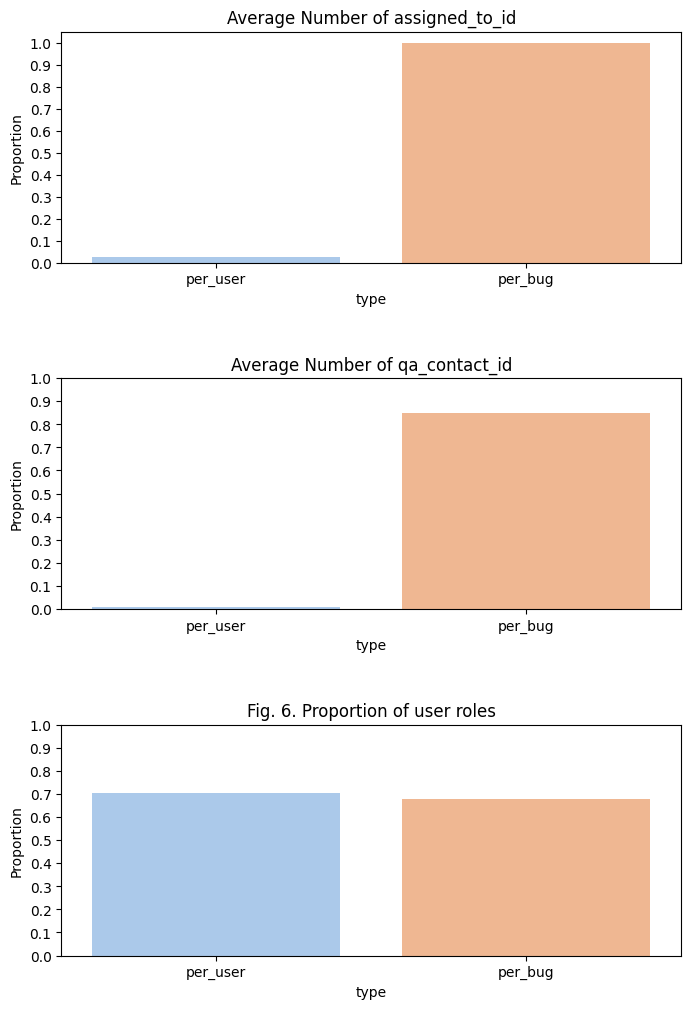

In [ ]:
#### Create subplots
fig, axes = plt.subplots(3, 1, figsize = (8, 12))
axes = axes.ravel()

# Create bar chart
for i in np.arange(len(l_df_2)):
    df_temp = l_df_2[i]
    #axes[i].bar(0.3, df_temp["per_user"], 0.2, label="a_user_is", color='orange')
    #axes[i].bar(0.7, df_temp["per_bug"], 0.2, label="a_bug_has", color='blue')
    # Convert to long format
    df_temp = df_temp.melt(var_name="type", value_name="proportion")
    sns.barplot(x="type", y="proportion", data=df_temp, ax=axes[i])
    axes[i].set_title(f"Average Number of {key_usertype[i]}")
    axes[i].set_ylabel(f"Proportion")
    axes[i].set_xticks([0,1])
    axes[i].set_yticks(np.arange(0.0, 1.1, 0.1))

# Show the plot
plt.title("Fig. 6. Proportion of user roles")
plt.subplots_adjust(hspace=0.5)
plt.show()

### Result Description:
- #### For the first 2 graphs, only a small group of less than 3% of the users play roles as a solver or QA, while almost every bug has a solver and more than 80% of bugs have a QA
- #### For the last graph, it can be deduced that more than 70% of the users were carbon copied (cc) and more than 60% of bugs were carbon copied to at least one user

### 2) Ratio of solver to bug by different categories
- #### This ratio reveals how many solvers are working on a same certain type of bug. The value is between 0 to 1. If the ratio is close to 1, it's indicated that for each bug within this category, almost one unique solver would be assigned with one bug. On the contrary, if the value is close to 0, it's inferred that there are fewer number of solvers are working on these bugs (one solver can be assigned with many bugs of the same category)

C:\Users\xiaoc\AppData\Local\Temp\ipykernel_27336\3969389386.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_temp = pd.read_sql_query(query, conn)


Avg solver of all product Mean:  0.246 Median:  0.113 

Avg solver of all severity Mean:  0.125 Median:  0.05 

Avg solver of all priority Mean:  0.068 Median:  0.052 



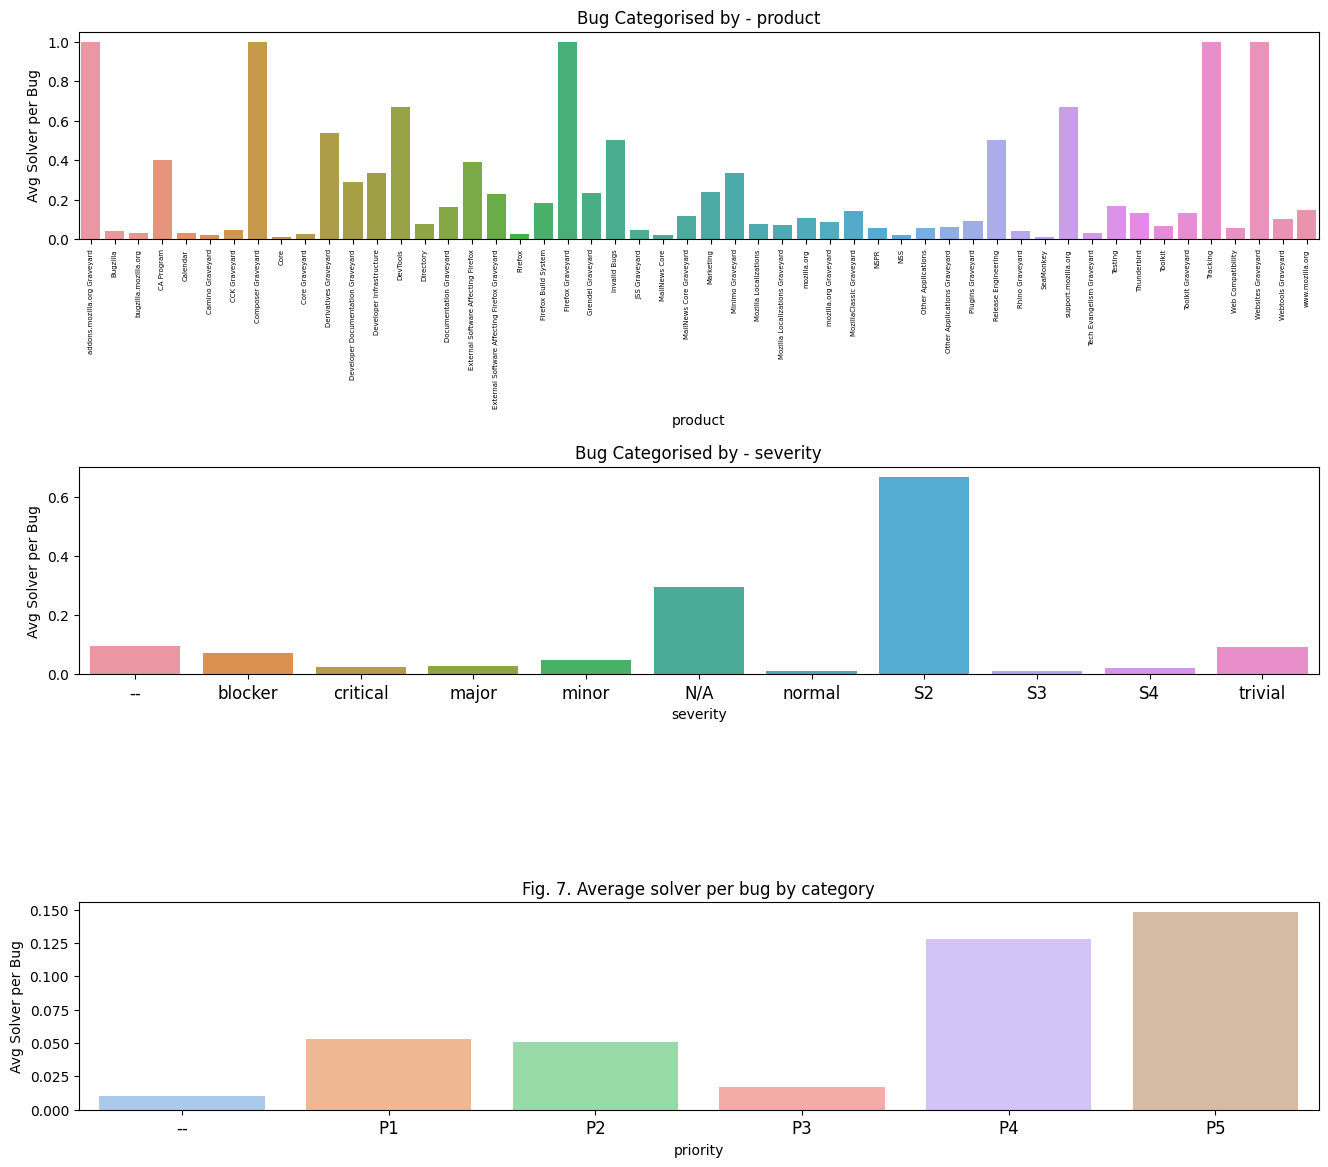

In [ ]:
#### SQL query: Average solver per bug
key_solverperbug = ["product", "severity", "priority"]
# Load data into dataframe list
l_df_1 = []
for i in key_solverperbug:
    query = f"""
SELECT
{i}, ROUND(COUNT(DISTINCT assigned_to_id)::decimal
/
COUNT(bug_id)::decimal, 3)
AS solver_avg FROM reports GROUP BY {i};
"""
    df_temp = pd.read_sql_query(query, conn)
    l_df_1.append(df_temp)


#### Create subplots
fig, axes = plt.subplots(3, 1, figsize = (16, 14))
axes = axes.ravel()
# Create bar chart
for i in np.arange(len(l_df_1)):
    df_temp = l_df_1[i]
    #axes[i].bar(df_temp[key_solverperbug[i]], df_temp["solver_avg"])
    sns.barplot(x=df_temp[key_solverperbug[i]], y=df_temp["solver_avg"], ax=axes[i])

    # Print mean, meidan values
    print("Avg solver of all", f"{key_solverperbug[i]}", "Mean: ", round(np.mean(df_temp["solver_avg"]), 3),
          "Median: ", round(np.median(df_temp["solver_avg"]), 3), "\n")

    axes[i].set_title(f"Bug Categorised by - {key_solverperbug[i]}")
    axes[i].set_ylabel("Avg Solver per Bug")
axes[0].set_xticklabels(l_df_1[0][key_solverperbug[0]], rotation=90, fontsize=5)
axes[1].set_xticklabels(l_df_1[1][key_solverperbug[1]], fontsize=12)
axes[2].set_xticklabels(l_df_1[2][key_solverperbug[2]], fontsize=12)

# Show the plot
plt.title("Fig. 7. Average solver per bug by category")
plt.subplots_adjust(hspace=1.1)
plt.show()

### Result Description:
- #### The 1st graph shows the ratio of solver to bug by product type, and the average ratio is approxiamtely 0.25, indicating that for one product, averagely 4 bugs are assigned to the same solver.
- #### The 2nd graph shows the ratio by bug severity. Only bugs with severity N/A and S2 are assigned to relatively more solvers.
- #### The 3rd graph shows the ratio by priority. The ratios of all priorities are overall low within a narrow range (0.01 - 0.15)

## 3 Timeseries Analysis
- #### Analysis regarding datetime is implemented within this section. The time intervals between each status of a bug are analysed.

### Time Series Analysis across different status changes (intervals)

In [ ]:
#### SQL query: Average time between status stages
# Load data into dataframe list
# Get necessary information from changes_hisory
query_3 = """
SELECT bug_id, added, removed, "when",
RANK() OVER (PARTITION BY bug_id ORDER BY "when" ASC) AS rank,
AGE("when"::date, LAG("when"::date) OVER (PARTITION BY bug_id ORDER BY "when" ASC)) AS days
FROM changes_history
WHERE field_name = 'status'
"""
df_time_1 = pd.read_sql_query(query_3, conn)

#### The time from when bug was created to the first status changed is unknown
#### Use the earliest creation date - creation_time to calculate the time from bug was created

query_4 = f"""
SELECT bug_id, creation_time FROM reports
"""
df_time_2 = pd.read_sql_query(query_4, conn)

C:\Users\xiaoc\AppData\Local\Temp\ipykernel_27336\4187848613.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_time_1 = pd.read_sql_query(query_3, conn)
C:\Users\xiaoc\AppData\Local\Temp\ipykernel_27336\4187848613.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_time_2 = pd.read_sql_query(query_4, conn)


In [ ]:
#### Calculate the time from when a bug was created and store each bug's stages time
# Create a dictionary to store different intervals
dic_status = {}
for index, row in df_time_1.iterrows():
    # If it's the first change record (which doesn't have creation date)
    if row["rank"] == 1:
        # Search the creation date with the same bug_id
        crea_date = df_time_2.loc[df_time_2["bug_id"] == row["bug_id"], "creation_time"]
        interval = (row["when"] - crea_date.squeeze()).days
    else:
        interval = row["days"].days
    # Check if the status change is already included in the dictionary
    # If not, create a list as the value to store intervals
    key_status = f"{row['removed']}_{row['added']}"
    if key_status not in dic_status:
        list_days = []
        dic_status[key_status] = list_days
    # Append the intervals to the list that corresponds to the specific status change
    dic_status[key_status].append(interval)
# Clean the keys
dic_status = {k: v for k, v in dic_status.items() if not (k.startswith("_") or k.endswith("_"))}
print(dic_status.keys())

dict_keys(['NEW_RESOLVED', 'RESOLVED_VERIFIED', 'NEW_ASSIGNED', 'ASSIGNED_RESOLVED', 'VERIFIED_RESOLVED', 'VERIFIED_REOPENED', 'REOPENED_RESOLVED', 'ASSIGNED_NEW', 'RESOLVED_REOPENED', 'REOPENED_NEW', 'CLOSED_REOPENED', 'RESOLVED_CLOSED', 'CLOSED_RESOLVED', 'REOPENED_ASSIGNED', 'VERIFIED_NEW', 'RESOLVED_NEW', 'VERIFIED_CLOSED', 'NEW_UNCONFIRMED', 'UNCONFIRMED_NEW', 'CLOSED_VERIFIED', 'RESOLVED_ASSIGNED', 'CLOSED_NEW', 'REOPENED_CLOSED', 'UNCONFIRMED_RESOLVED', 'REOPENED_VERIFIED', 'RESOLVED_UNCONFIRMED', 'REOPENED_UNCONFIRMED', 'VERIFIED_ASSIGNED', 'VERIFIED_UNCONFIRMED', 'UNCONFIRMED_ASSIGNED', 'CLOSED_UNCONFIRMED', 'ASSIGNED_UNCONFIRMED', 'UNCONFIRMED_CLOSED', 'NEW_VERIFIED', 'NEW_REOPENED'])


In [ ]:
#### Count the number of records of each status change
#### Calculate the average days and variance of each interval
key_status = ["count", "avg_span", "var_span"]
# Create a list to store dataframes that contains information to be visualised
l_df_3 = []
for i in key_status:
    dic_temp = {}
    if i == "count":
        for j in dic_status:
            dic_temp[j] = len(dic_status[j])
    elif i == "avg_span":
        for j in dic_status:
            dic_temp[j] = np.mean(dic_status[j])
    elif i == "var_span":
        for j in dic_status:
            dic_temp[j] = np.var(dic_status[j])
    df_temp = pd.DataFrame(dic_temp, index=[0]).transpose()
    df_temp = df_temp.reset_index()
    df_temp.columns = ["Interval", f"{i}"]
    l_df_3.append(df_temp)

count Mean:  19801.628571428573 Median:  870.0 

avg_span Mean:  451.3149270851304 Median:  70.45427608051497 

var_span Mean:  682404.8535765158 Median:  59148.8023883402 



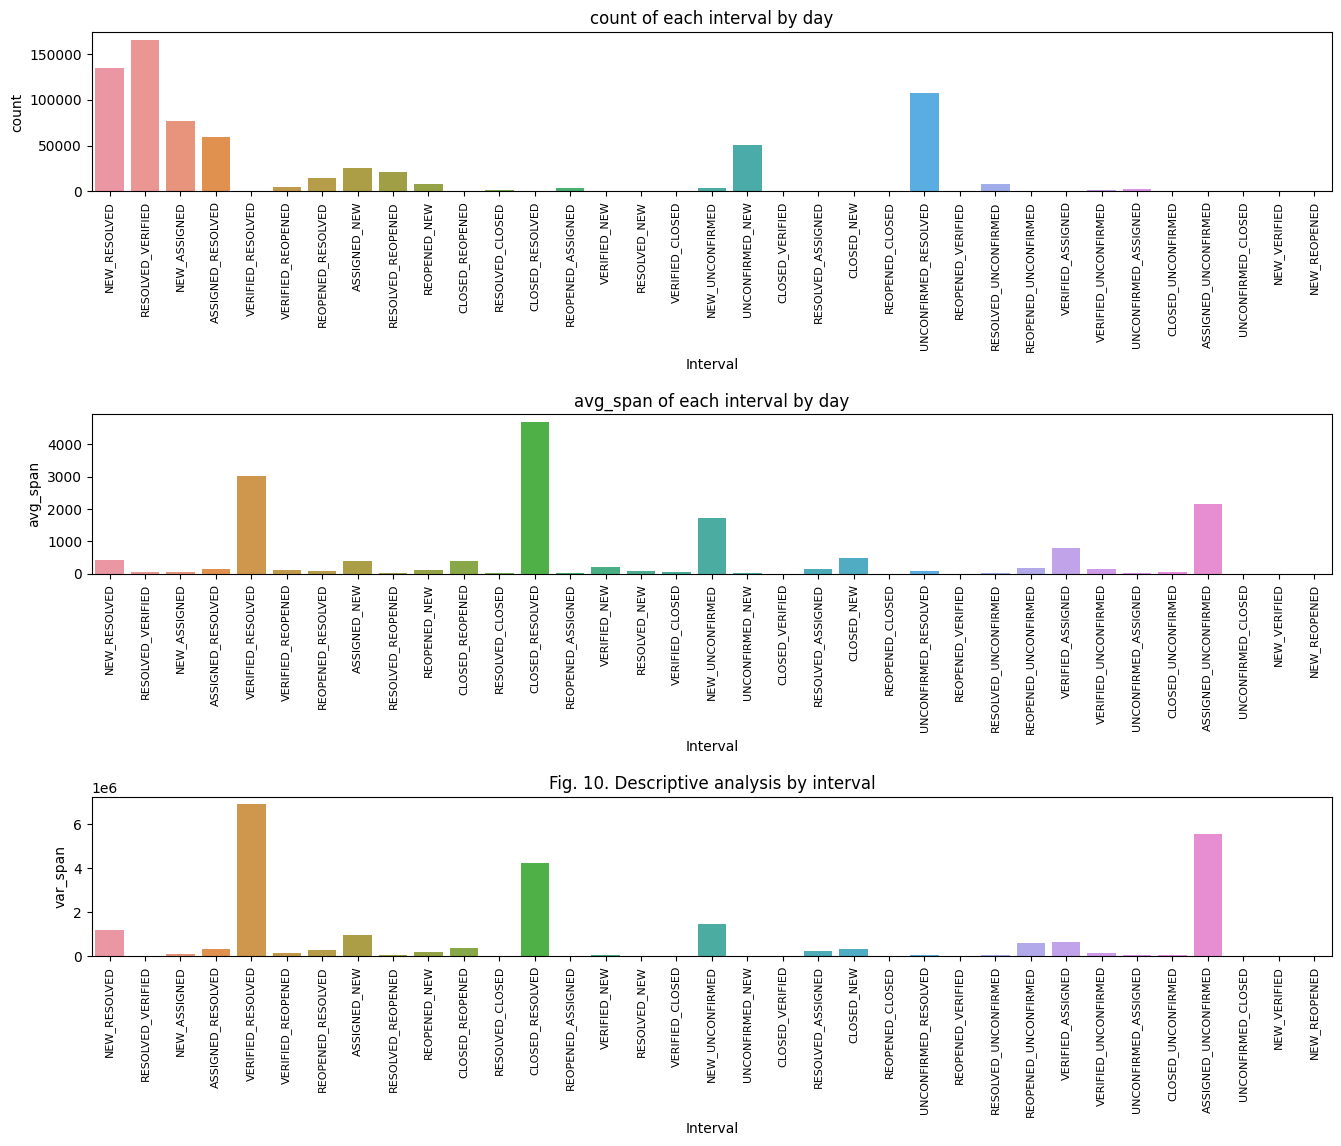

In [ ]:
#### Create subplots
fig, axes = plt.subplots(3, 1, figsize = (16, 12))
axes = axes.ravel()

# Create bar chart
for i in np.arange(len(l_df_3)):
    df_temp = l_df_3[i]
    #axes[i].bar(df_temp["Status_change"], df_temp[key_status[i]])
    sns.barplot(x=df_temp["Interval"], y=df_temp[key_status[i]], ax=axes[i])

    # Print mean, meidan values
    print(f"{key_status[i]}", "Mean: ", np.mean(df_temp[key_status[i]]),
          "Median: ", np.median(df_temp[key_status[i]]), "\n")

    axes[i].set_title(f"{key_status[i]} of each interval by day")
    axes[i].set_ylabel(f"{key_status[i]}")
    axes[i].set_xticklabels(df_temp["Interval"], rotation=90, fontsize=8)

# Show the plot
plt.title("Fig. 10. Descriptive analysis by interval")
plt.subplots_adjust(hspace=1.4)
plt.show()

## Result Description

# Close Connection

In [ ]:
# Finally we are done, close the cursor and connection
cursor.close()
conn.close()